# Introduction

<div class="alert alert-warning">
<font color=black>

**What?** Grid and random search

</font>
</div>

# Import modules

In [1]:
import numpy as np
import pandas as pd

## K-Fold Cross Validation

One of the most common technique for model evaluation and model selection in machine learning practice is K-fold cross validation. The main idea behind cross-validation is that each observation in our dataset has the opportunity of being tested. K-fold cross-validation is a special case of cross-validation where we iterate over a dataset set k times. In each round, we split the dataset into $k$ parts: one part is used for validation, and the remaining $k-1$ parts are merged into a training subset for model evaluation. The figure below illustrates the process of 5-fold cross-validation:

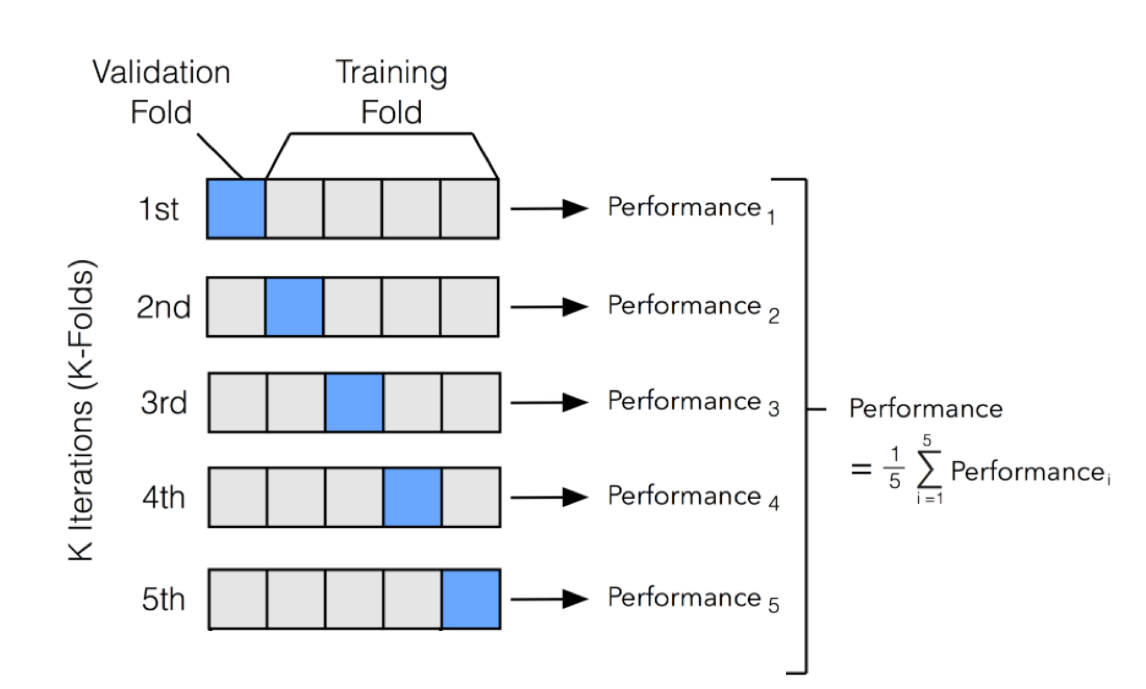

We use a learning algorithm with fixed hyperparameter settings to fit models to the training folds in each iteration. In 5-fold cross-validation, this procedure will result in 5 models fitted on distinct yet partly overlapping training sets and evaluated on non-overlapping validation sets. Eventually, we compute the cross-validation performance as the arithmetic mean over the $k$ performance estimates from the validation sets. The main benefit behind this approach versus a simple train/test split is to reduce the pessimistic bias by using more training data in contrast to setting aside a relatively large portion of the dataset as test data.

The following section shows a vanilla implementation of how to generate a K-fold data split.

In [2]:
class KFolds:
    """
    K-Folds cross-validation
    Provides train/test indices to split data in train/test sets. Split
    dataset into k consecutive folds; Each fold is then used once as 
    a validation while the k - 1 remaining folds form the training set

    Parameters
    ----------
    n_splits : int
        number of folds. Must be at least 2
    
    shuffle : bool, default True
        whether to shuffle the data before splitting into batches
    
    seed : int, default 4321
        When shuffle = True, pseudo-random number generator state used for
        shuffling; this ensures reproducibility
    """
    def __init__(self, n_splits, shuffle = True, seed = 4321):
        self.seed = seed
        self.shuffle = shuffle
        self.n_splits = n_splits
        
    def split(self, X):
        """pass in the data to create train/test split for k fold"""
        # shuffle modifies indices inplace
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        if self.shuffle:
            rstate = np.random.RandomState(self.seed)
            rstate.shuffle(indices)

        for test_mask in self._iter_test_masks(n_samples, indices):
            train_index = indices[np.logical_not(test_mask)]
            test_index = indices[test_mask]
            yield train_index, test_index
        
    def _iter_test_masks(self, n_samples, indices):
        """
        create the mask for the test set, then the indices that
        are not in the test set belongs in the training set
        """
        # indicate the number of samples in each fold, and also
        # make sure the ones that are not evenly splitted also
        # gets assigned to a fold (e.g. if we do 2 fold on a
        # dataset that has 5 samples, then 1 will be left out,
        # and has to be assigned to one of the other fold)
        fold_sizes = (n_samples // self.n_splits) * np.ones(self.n_splits, dtype = np.int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            test_mask = np.zeros(n_samples, dtype = np.bool)
            test_mask[test_indices] = True
            yield test_mask
            current = stop

In [3]:
# create some sample data
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [5, 6]])
y = np.array([1, 2, 3, 4, 5])

kf = KFolds(n_splits = 2, shuffle = False, seed = 4312)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

from sklearn.model_selection import KFold
print('\nconfirm results with scikit-learn')
kf = KFold(n_splits = 2, shuffle = False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [3 4] TEST: [0 1 2]
TRAIN: [0 1 2] TEST: [3 4]

confirm results with scikit-learn
TRAIN: [3 4] TEST: [0 1 2]
TRAIN: [0 1 2] TEST: [3 4]


Here we implemented the simple version of K-fold, we should also keep in mind that some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold). Stratified basically means each set contains approximately the same percentage of samples of each target class as the complete set.

---

Now that have a sense of what K-fold cross validation is doing, let's look at how it can be used with hyperparameter tuning.

So the general process is:

- We split our dataset into two parts, a training and an independent test set; we tuck away the test set for the final model evaluation step at the end
- In the second step, we can now experiment with various hyperparameter settings; we could use Bayesian Optimization, Randomized Search, or plain old Grid Search (more on this later, think of it as different ways of generating hyperparameter combinations). For each hyperparameter configuration, we apply the K-fold cross validation on the training set, resulting in multiple models and performance estimates. See figure below:

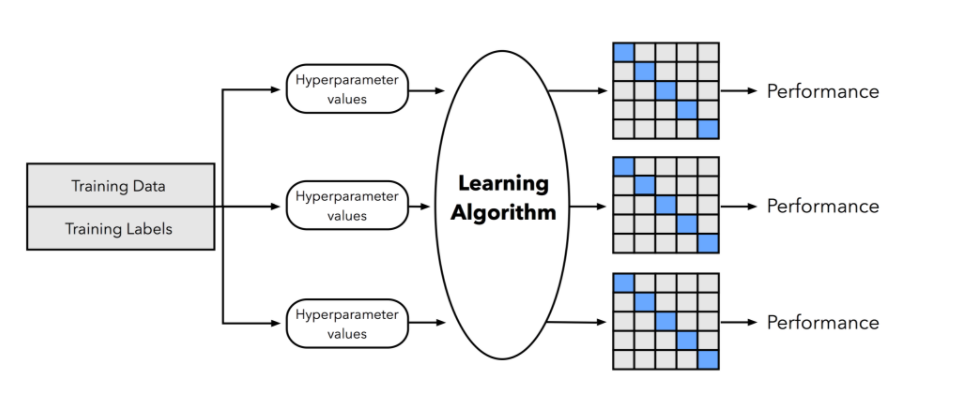


- After finding the best set of hyperparameter, we take the best-performing setting for that model and use the complete training set for model fitting.

- Then we make use of the independent test set we withheld at the beginning to evaluate the model that we obtained

Let's now tackle each step one at a time.

## Grid Search

There are various ways to perform hyperparameter tuning and one of them is Grid Search. This method exhaustively considers all parameter combinations and picks the best one based on the model that gives the best performance (we can specify the performance criteria).

In [4]:
from itertools import product
from sklearn.model_selection import ParameterGrid

# suppose we have hyperparameter 'a' and 'b' and
# we wish to test out value 1, 2 for a and
# True, False for b, so grid search will simply
# evaluate all four possible combinations
param_grid = {'a': [1, 2], 'b': [True, False]}

# for reproducibility, always sort the keys of a dictionary
# this will become a list of paired tuples
items = sorted(param_grid.items())
print('sorted parameters, values: ', items)
print()

# unpack the list of tuples into two lists tuples, so what's originally 
# a list of items [('a', [1, 2]), ('b', [True, False])], becomes
# two lists ('a', 'b'), ([1, 2], [True, False]), with all the keys being the parameter
# and the value being the list of possible values that the parameter can take
# http://stackoverflow.com/questions/7558908/unpacking-a-list-tuple-of-pairs-into-two-lists-tuples
key, value = zip(*items)
print('parameters: ', key)
print('values', value)
print()

# unpack the list of values to compute the cartesian product
# [(1, True), (1, False), (2, True), (2, False)], and zip it
# back to the original key
print('grid search parameters')
cartesian = product(*value)
for v in cartesian:
    params = dict(zip(key, v))
    print(params)

sorted parameters, values:  [('a', [1, 2]), ('b', [True, False])]

parameters:  ('a', 'b')
values ([1, 2], [True, False])

grid search parameters
{'a': 1, 'b': True}
{'a': 1, 'b': False}
{'a': 2, 'b': True}
{'a': 2, 'b': False}


In [5]:
# confirm with scikit-learn's output
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True},
 {'a': 1, 'b': False},
 {'a': 2, 'b': True},
 {'a': 2, 'b': False}]

In [6]:
# putting it all into a function
def _get_param_grid(param_grid):
    """
    create cartesian product of parameters (grid search),
    this will be a generator that will allow looping through
    all possible parameter combination
    
    Reference
    ---------
    scikit-learn ParameterGrid
    - https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py#L44
    """
    # for reproducibility, always sort the keys of a dictionary
    items = sorted(param_grid.items())
    
    # unpack parameter and the range of values
    # into separate list; then unpack the range 
    # of values to compute the cartesian product
    # and zip it back to the original key
    key, value = zip(*items)
    cartesian = product(*value)
    for v in cartesian:
        params = dict(zip(key, v))
        yield params


param_grid = {'a': [1, 2], 'b': [True, False]}
params = _get_param_grid(param_grid)
for p in params:
    print(p)

{'a': 1, 'b': True}
{'a': 1, 'b': False}
{'a': 2, 'b': True}
{'a': 2, 'b': False}


And now we can tie it with the K-fold that we learned earlier. To do so, we will make use of [joblib](https://pythonhosted.org/joblib/parallel.html), a package that allow us to write parallel processing code relatively easy.

An "embarrassingly parallel" computing task is one in which each calculation is independent of the ones that came before or after it. For example, squaring each number in the list [1, 2, 3, 4, 5] is embarrassingly parallel because the square of 2 does not depend on 1, 3 on 2, and so on. So when performing these types of calculations, we can and should run these operations using different processors/cores (or course for this simple problem it's definitely not worth it ...). In our case, because fitting the model using different hyperparameters and using different folds of the data to fit the model are all independent computations, the problem falls under the "embarrassingly parallel" category.

In [7]:
from copy import deepcopy
from joblib import Parallel, delayed

class GridSearch:
    """
    Exhaustive search over specified parameter values for an estimator

    Parameters
    ----------
    estimator : estimator object
        This is assumed to implement the scikit-learn estimator interface,
        it needs to have a .fit and set_params method

    param_grid : dict
        Dictionary with parameters names (string) as keys and lists of
        parameter settings to try as values

    scorer : callable function
        scorer callable object / function with 
        signature scorer(estimator, X, y)

    cv : int or cross-validation generator (e.g. Kfolds)
        Determines the cross-validation splitting strategy. 
        Possible inputs for cv are:
        - integer, to specify the number of folds in a KFold
        - An object to be used as a cross-validation generator

    fit_params : dict, optional
        Additional parameters to pass to the fit method

    n_jobs : int, default -1
        Number of jobs to run in parallel, if the model already fits
        extremely fast on the data, then specify 1 so that there's no 
        overhead of spawning different processes to do the computation

    verbose : bool, default True
        Whether to print the fitting progress

    pre_dispatch : int, or string, default '2*n_jobs'
        Controls the number of jobs that get dispatched during parallel
        execution. Reducing this number can be useful to avoid an
        explosion of memory consumption when more jobs get dispatched
        than CPUs can process. This parameter can be:
            - None, in which case all the jobs are immediately
              created and spawned. Use this for lightweight and
              fast-running jobs, to avoid delays due to on-demand
              spawning of the jobs
            - An int, giving the exact number of total jobs that are
              spawned
            - A string, giving an expression as a function of n_jobs,
              as in '2*n_jobs'

    refit : bool, default True
        Refit the estimator with best set of parameters on the entire dataset
        If "False", it is impossible to make whether predictions using
        this GridSearch instance after fitting

    Attributes
    ----------
    best_estimator_ : estimator
        Best estimator that was chosen by the search, i.e. estimator which 
        gave best test score. Not available if refit = False

    best_score_ : float
        Best score on the hold out data

    best_params_ : dict
        Parameter settings that gave the best results on the hold out data

    cv_results_ : DataFrame
        records the average train/test score for each hyperparameter, result
        is sorted by the test score
    
    Reference
    ---------
    scikit-learn GridSearchCV
    - http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    """
    def __init__(self, estimator, scorer, cv, param_grid,
                 fit_params = None, verbose = True, n_jobs = -1, 
                 pre_dispatch = '2*n_jobs', refit = True):
        self.cv = cv
        self.refit = refit
        self.n_jobs = n_jobs
        self.scorer = scorer
        self.verbose = verbose
        self.estimator = estimator
        self.param_grid = param_grid
        self.fit_params = fit_params
        self.pre_dispatch = pre_dispatch     
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : 2d nd.array, shape = [n_samples, n_features]
            training vector, where n_samples in the number of samples and
            n_features is the number of features.
        
        y : 1d nd.array, shape = [n_samples]
            target/label relative to X for classification or regression
        """
        # object used as a cross-validation generator
        # is passed without any modification
        if isinstance(self.cv, int):
            cv = KFold(n_splits = self.cv, shuffle = True)
        else:
            cv = self.cv
        
        # obtain the train/test set index, the parameters
        # and perform cross validation
        cv_iter = cv.split(X)
        
        # obtain the hyperparameter settings, we will need to turn it
        # to the list or else the iterator will be exhausted after we
        # loop through it once (i.e. one of the fold)
        params_iterable = list(_get_param_grid(self.param_grid))
        fit_params = self.fit_params if self.fit_params is not None else {}
        
        # hyperparameter tuning + K-fold cross validation
        parallel = Parallel(n_jobs = self.n_jobs, verbose = self.verbose, 
                            pre_dispatch = self.pre_dispatch)
        output = parallel(delayed(self._fit_and_score)(deepcopy(self.estimator), 
                                                       X, y, self.scorer,
                                                       train_index, test_index, 
                                                       parameters, fit_params)
                          for train_index, test_index in cv_iter
                          for parameters in params_iterable)

        # unpack training/testing scores
        n_splits = cv.n_splits
        n_candidates = len(params_iterable)
        train_score, test_score = zip(*output)
        train_score = np.array(train_score, dtype = np.float64).reshape(n_splits, n_candidates)
        test_score = np.array(test_score, dtype = np.float64).reshape(n_splits, n_candidates)
        
        # obtain the best score and parameter using the 
        # best mean test scores across all folds, where
        # best here means the higher the better
        mean_test_score = np.mean(test_score, axis = 0)
        best_index = np.argmax(mean_test_score)
        self.best_score_ = mean_test_score[best_index]
        self.best_param_ = params_iterable[best_index]

        # list the mean, std train and test score
        # for each parameters combination;
        # not sure if 'params', the column with the
        # values in the dictionary format is useful or not
        mean_train_score = np.mean(train_score, axis = 0)
        std_test_score = np.std(test_score, axis = 0)
        std_train_score = np.std(train_score, axis = 0)
        cv_results = {'mean_train_score': mean_train_score,
                      'std_train_score': std_train_score,
                      'mean_test_score': mean_test_score,
                      'std_test_score': std_test_score}

        # ensure the columns appear in this order
        # (train score, test score, parameters)
        # and order by the best test score
        cols = ['mean_train_score', 'std_train_score', 
                'mean_test_score', 'std_test_score']
        cv_results = pd.DataFrame(cv_results, columns = cols)
        df_params = pd.DataFrame(params_iterable)
        cv_results = pd.concat([cv_results, df_params], axis = 1)
        cv_results['params'] = params_iterable
        cv_results = (cv_results.
                      sort_values(['mean_test_score', 'std_test_score'], ascending = False).
                      reset_index(drop = True))
        self.cv_results_ = cv_results
        
        # refit on the entire dataset after performing cross validation
        if self.refit:
            best_estimator = deepcopy(self.estimator)
            best_estimator.set_params(**self.best_param_)
            best_estimator.fit(X, y, **fit_params)
            self.best_estimator_ = best_estimator
        
        return self
    
    def _fit_and_score(self, estimator, X, y, scorer, 
                       train_index, test_index,
                       parameters, fit_params):
        # create the train/test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit the model using the current hyperparameter setting
        estimator.set_params(**parameters)
        estimator.fit(X_train, y_train, **fit_params)

        # obtain the train/test score
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
        train_score = scorer(y_train, y_pred_train)
        test_score = scorer(y_test, y_pred_test)
        output = [train_score, test_score]
        return output
    
    def predict(self, X):
        """call predict on the estimator with the best found parameter"""
        if not self.refit:
            raise ValueError('Only available if refit=True')
        
        return self.best_estimator_.predict(X)

In [8]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# load a toy dataset,
# ideally we should also perform a train/test split
# here, and use the test set as our final validation
# of the model's performance
iris = load_iris()
X = iris.data
y = iris.target

# grid search parameters
cv = 3
scorer = accuracy_score
clf = RandomForestClassifier()
param_grid = {'max_depth': [3, None],
              'criterion': ['gini', 'entropy']}

# fit grid search
grid_search = GridSearch(estimator = clf, scorer = scorer, cv = cv, param_grid = param_grid)
grid_search.fit(X, y)
grid_search.cv_results_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.8s finished


,mean_train_score,std_train_score,mean_test_score,std_test_score,criterion,max_depth,params
0,1.00,0.000000,0.953333,0.009428,gini,NaN,"{'criterion': 'gini', 'max_depth': None}"
1,0.98,0.008165,0.946667,0.018856,gini,3.0,"{'criterion': 'gini', 'max_depth': 3}"
2,0.98,0.008165,0.946667,0.018856,entropy,3.0,"{'criterion': 'entropy', 'max_depth': 3}"
3,1.00,0.000000,0.940000,0.016330,entropy,NaN,"{'criterion': 'entropy', 'max_depth': None}"


## Random Search

While grid search is a widely used method for parameter optimization, other search methods such as random search have more favorable properties. So instead of listing out the list of values to try for each parameter and then trying out all possible combinations of these values, in random search each parameter is sampled from a distribution. The user can specify the distribution to sample from and how many parameters should be sampled (this can be a big benefit if we're limited on computation budget).

The rationale behind why random search can be better than the much more robust-looking grid-search can be nicely illustrated by the figure below:

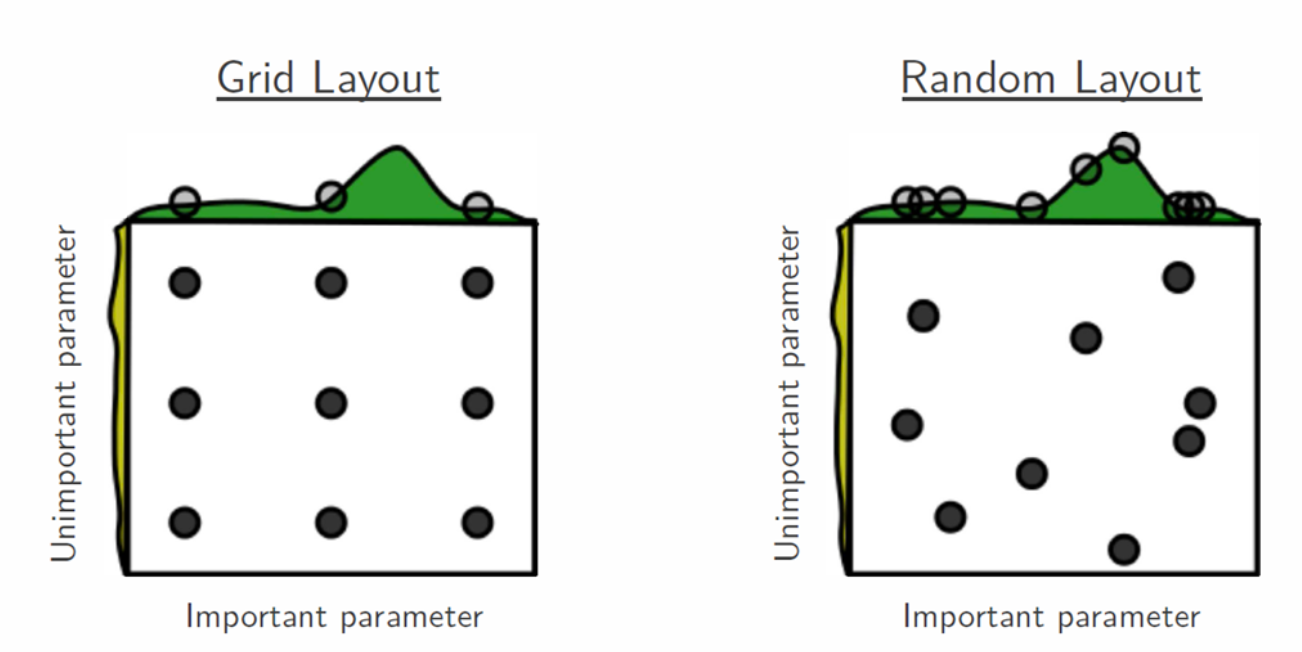

The idea is that in most cases the bumpy surface of the objective/cost function is not as bumpy in all dimensions. In other words, some parameters have much less effect on the objective/cost function than others. Hence, given the same amount of trials, using random search allows us to explore the space more.

In [9]:
from scipy.stats import randint

# we can use distributions from the scipy.stats module
# or we can write our own distribution, but to use 
# scikit-learn, it has to have a .rvs method
# that generates a random number from the distribution
# e.g. a random uniform distribution
randint(low = 3, high = 8).rvs()

6

In [10]:
def _get_param_sampler(param_distributions, n_iters, random_state):
    """
    generator on parameters sampled from given distributions
    
    param_distributions : dict
        Dictionary with parameters names (string) as keys and distributions
        or lists of parameters to try. Distributions must provide a ``rvs``
        method for sampling (such as those from scipy.stats.distributions).
        If a list is given, it is sampled uniformly.
    
    n_iters : int
        Number of parameter settings that are sampled. n_iters trades
        off runtime vs quality of the solution
        
    random_state : int
        seed for random sampling
    
    Reference
    ---------
    scikit-learn's ParameterSampler
    - https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py#L182
    """
    # for reproducibility, always sort the keys of a dictionary
    items = sorted(param_distributions.items())
    
    rstate = np.random.RandomState(random_state)
    for _ in range(n_iters):
        params = dict()
        for k, v in items:
            if hasattr(v, 'rvs'):
                params[k] = v.rvs(random_state = rstate)
            else:
                params[k] = v[rstate.randint(len(v))]

        yield params


n_iters = 5
random_state = 1234
param_distributions = {'a': randint(low = 3, high = 8), 'b': [True, False]}
list(_get_param_sampler(param_distributions, n_iters, random_state))

[{'a': 6, 'b': True},
 {'a': 7, 'b': True},
 {'a': 3, 'b': False},
 {'a': 4, 'b': False},
 {'a': 4, 'b': True}]

## Random & Grid Search Comparison

The following section demonstrates how to use the scikit-learn `GridSearchCV` and `RandomizedSearchCV`. On this particular example using randomized search and the grid search resulted in similar performance when tuning the same parameters, while the run time for randomized search is drastically lower. Note that your mileage may vary. This result is not saying that `RandomizedSearchCV` will always outperform `GridSearchCV`.

In [11]:
from time import time
from scipy.stats import randint
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# load another toy dataset
digits = load_digits()
X = digits.data
y = digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators = 20)

def report(results):
    """report best scores and corresponding parameters"""
    print('Best score obtained: {0}'.format(results.best_score_))
    print('Parameters:')
    for param, value in results.best_params_.items():
        print('\t{}: {}'.format(param, value))


# specify parameters and distributions to sample from
param_dist = {'max_depth': randint(low = 3, high = 11),
              'max_features': randint(low = 3, high = 11),
              'criterion': ['gini', 'entropy']}

# run randomized search
# set the number of samples to
# be half of the grid search
n_iter_search = 24
random_search = RandomizedSearchCV(clf, param_distributions = param_dist,
                                   n_iter = n_iter_search, random_state = 789)
start = time()
random_search.fit(X, y)
elapse = time() - start
message = 'RandomizedSearchCV took {:.2f} seconds for {} parameter settings'
print(message.format(elapse, n_iter_search))
report(random_search)
print()

# use a full grid over all parameters
param_grid = {'max_depth': np.arange(3, 11),
              'max_features': [1, 3, 11],
              'criterion': ['gini', 'entropy']}

# run grid search
grid_search = GridSearchCV(clf, param_grid = param_grid)
start = time()
grid_search.fit(X, y)
elapse = time() - start
n_iter_search = len(grid_search.cv_results_['params'])
message = 'GridSearchCV took {:.2f} seconds for {} parameter settings'
print(message.format(elapse, n_iter_search))
report(grid_search)

RandomizedSearchCV took 6.37 seconds for 24 parameter settings
Best score obtained: 0.9265645311049211
Parameters:
	criterion: gini
	max_depth: 9
	max_features: 5

GridSearchCV took 11.33 seconds for 48 parameter settings
Best score obtained: 0.9304596100278552
Parameters:
	criterion: entropy
	max_depth: 9
	max_features: 11


# References

- [Github: scikit-learn's KFold](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/model_selection/_split.py#L347)
- [Github: scikit-learn's GridSearch](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/model_selection/_search.py#L685)
- [Scikit-learn Documentation: Tuning the hyper-parameters of an estimator](http://scikit-learn.org/stable/modules/grid_search.html)
- [Scikit-learn Documentation: Cross-validation: evaluating estimator performance](http://scikit-learn.org/stable/modules/cross_validation.html)
- [Scikit-learn Documentation: Comparing randomized search and grid search for hyperparameter estimation](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html#sphx-glr-auto-examples-model-selection-randomized-search-py)
- [Blog: Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881)
- [Blog: Model evaluation, model selection, and algorithm selection in machine learning Part III - Cross-validation and hyperparameter tuning](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html)
- [Reference code](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/model_selection/model_selection.ipynb)<br>                                                                                                          